# Final Project: Finding a Well-Tuned Model for Kaggle’s *Petals to the Metal* Competition

In [1]:
from __future__ import print_function
from __future__ import division
import os
import shutil
import numpy as np
import torch
torch.manual_seed(17)    # Wren added this per the recommendation here: https://pytorch.org/vision/stable/transforms.html
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from classifier import Classifier
import pdb
from dataset_converter_for_pytorch import PRODUCE_DATASET, PRODUCE_TESTING_DATASET
from datetime import datetime
from plyer import notification
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

# For pretrained models
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

## Architecture parameters

In [2]:
# Number of convolutional layers
#N_CONV_LAYERS = 5
# Number of fully connected layers
#N_FC_LAYERS = 7
# Batch size
BS = 32
# Weight decay (for Adam)
WD = 0
# A trous convolution dilation factor (default is 1)
#AT = 1
# Learning rate (for Adam)
LR = 0.001


# For pretrained model (set model_name to None if not using one)
model_name = "resnet50"
num_classes = 104
feature_extract = False    # When False, we finetune the whole model.

## Reading Kaggle Data

### Loading Training and Validation Data

In [3]:
ds_train, ds_val = PRODUCE_DATASET()

['kaggle/input/tpu-getting-started\\tfrecords-jpeg-192x192\\train\\00-192x192-798.tfrec', 'kaggle/input/tpu-getting-started\\tfrecords-jpeg-192x192\\train\\01-192x192-798.tfrec', 'kaggle/input/tpu-getting-started\\tfrecords-jpeg-192x192\\train\\02-192x192-798.tfrec', 'kaggle/input/tpu-getting-started\\tfrecords-jpeg-192x192\\train\\03-192x192-798.tfrec', 'kaggle/input/tpu-getting-started\\tfrecords-jpeg-192x192\\train\\04-192x192-798.tfrec']


In [4]:
"""Show dimensions of the most important attributes of ds_train and ds_val"""
print(ds_train.id[0])
print(f"ds_train.id is a {type(ds_train.id)} of {len(ds_train.id)} {type(ds_train.id[0])}s")
print(f"ds_train.classes is a {type(ds_train.classes)} of {len(ds_train.classes)} {type(ds_train.classes[0])}s")
print(f"ds_train.image is a {type(ds_train.image)} of {len(ds_train.image)} {type(ds_train.image[0])}s")
print("")
print(f"ds_val.id is a {type(ds_val.id)} of {len(ds_val.id)} {type(ds_val.id[0])}s")
print(f"ds_val.classes is a {type(ds_val.classes)} of {len(ds_val.classes)} {type(ds_val.classes[0])}s")
print(f"ds_val.image is a {type(ds_val.image)} of {len(ds_val.image)} {type(ds_val.image[0])}s")

338ab7bac
ds_train.id is a <class 'list'> of 51012 <class 'str'>s
ds_train.classes is a <class 'list'> of 51012 <class 'int'>s
ds_train.image is a <class 'list'> of 51012 <class 'bytes'>s

ds_val.id is a <class 'list'> of 14848 <class 'str'>s
ds_val.classes is a <class 'list'> of 14848 <class 'int'>s
ds_val.image is a <class 'list'> of 14848 <class 'bytes'>s


### Visualizing the Data

In [5]:
# SHOW SOME IMAGES FROM TRAINING SET
"""
for i in range(20):
    this_image = ds_train[i][0]
    
    # Convert to levels that plt can show.
    smooshed_image = this_image / (this_image.max() - this_image.min())
    shifted_image = smooshed_image - smooshed_image.min()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(shifted_image.permute(1, 2, 0))
"""

# SHOW THE SAME TRAINING IMAGE REPEATEDLY TO SEE IF IT'S BEING AUGMENTED CORRECTLY
"""
for i in range(20):
    this_image = ds_train[0][0]
    
    # Convert to levels that plt can show.
    smooshed_image = this_image / (this_image.max() - this_image.min())
    shifted_image = smooshed_image - smooshed_image.min()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(shifted_image.permute(1, 2, 0))
"""


# SAVE ALL IMAGES FROM TRAINING SET
"""
for i in range(len(ds_train.id)):
    this_image = ds_train[i][0]
    
    # Convert to levels that plt can show.
    smooshed_image = this_image / (this_image.max() - this_image.min())
    shifted_image = smooshed_image - smooshed_image.min()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(shifted_image.permute(1, 2, 0))
    plt.savefig(f"images_for_human_inspection/training/training_{i}")
    plt.close()
"""
    


# SAVE ALL IMAGES FROM VALIDATION SET
"""
for i in range(len(ds_val.id)):
    this_image = ds_val[i][0]
    
    # Convert to levels that plt can show.
    smooshed_image = this_image / (this_image.max() - this_image.min())
    shifted_image = smooshed_image - smooshed_image.min()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(shifted_image.permute(1, 2, 0))
    plt.savefig(f"images_for_human_inspection/validation/validation_{i}")
    plt.close()
"""

'\nfor i in range(len(ds_val.id)):\n    this_image = ds_val[i][0]\n    \n    # Convert to levels that plt can show.\n    smooshed_image = this_image / (this_image.max() - this_image.min())\n    shifted_image = smooshed_image - smooshed_image.min()\n    \n    plt.figure(figsize=(10, 10))\n    plt.imshow(shifted_image.permute(1, 2, 0))\n    plt.savefig(f"images_for_human_inspection/validation/validation_{i}")\n    plt.close()\n'

# Classification

In [6]:
"""Show which device will be doing computation"""
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(f"cuda device 0 is {torch.cuda.get_device_name(0)}")

cuda:0
cuda device 0 is NVIDIA GeForce RTX 3080 Laptop GPU


In [7]:
"""Create dataloaders"""
train_loader = torch.utils.data.DataLoader(dataset=ds_train,
                                               batch_size=BS, 
                                               shuffle=True,
                                               num_workers=1)
val_loader = torch.utils.data.DataLoader(dataset=ds_val,
                                               batch_size=BS, 
                                               shuffle=True,
                                               num_workers=1)

In [8]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()

In [9]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True, show_confusion_matrix=False, return_guesses=False):
    """Return validation metrics.  Doesn't change the classifier."""
    if return_guesses and not show_confusion_matrix:
        raise ValueError("Wren's code might not yet be able to return guesses without showing confusion matrix.  Request both for ease.")
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0))    # Will be made of labels
        y_score = None    # Will be made of logits
        for i, (images, labels) in enumerate(test_loader):    # Each iteration is one minibatch
            images, labels = images.to(device), labels.to(device)    # labels should have shape 32.  (According to nn.CrossEntropyLoss)
            logits = classifier(images)    # logits should have shape 32, 104.  (According to nn.CrossEntropyLoss)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            if y_score is None:
                y_score = logits.cpu().numpy()
            else:
                y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss.item())
        aps = []
        class_guesses = np.argmax(y_score, axis=1)
        accuracy = np.mean(class_guesses == y_true)
        #for i in range(1, y_true.shape[1]):
            #ap = average_precision_score(y_true[:, i], y_score[:, i])
            #if print_ind_classes:
                #print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(VOC_CLASSES[i], ap))
            #aps.append(ap)
        
        #mAP = np.mean(aps)
        test_loss = np.mean(losses)
        print("Accuracy: {0:.4f}".format(accuracy))
        #print('mAP: {0:.4f}'.format(mAP))
        print('Validation/testing loss: {}'.format(test_loss))
    
    # Show confusion matrix
    if show_confusion_matrix:
        confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true.tolist(), class_guesses.tolist()))
        fig, ax = plt.subplots(figsize=(7, 5))
        sns.heatmap(confusion_matrix_df, annot=True, ax=ax)
        
        #cm = confusion_matrix(y_true.tolist(), class_guesses.tolist())
        #print(cm)
    
    # Return metrics    
    #return mAP, test_loss, aps
    if return_guesses:
        return accuracy, test_loss, class_guesses.tolist()
    else:
        return accuracy, test_loss

## Modifying the network 

The network you are given as is will allow you to reach around 0.15-0.2 mAP. To meet the benchmark for this assignment you will need to improve the network. There are a variety of different approaches you should try:

* Network architecture changes
    * Number of layers: try adding layers to make your network deeper
    * Batch normalization: adding batch norm between layers will likely give you a significant performance increase
    * Residual connections: as you increase the depth of your network, you will find that having residual connections like those in ResNet architectures will be helpful
* Optimizer: Instead of plain SGD, you may want to add a learning rate schedule, add momentum, or use one of the other optimizers you have learned about like Adam. Check the `torch.optim` package for other optimizers
* Data augmentation: You should use the `torchvision.transforms` module to try adding random resized crops and horizontal flips of the input data. Check `transforms.RandomResizedCrop` and `transforms.RandomHorizontalFlip` for this
* Epochs: Once you have found a generally good hyperparameter setting try training for more epochs
* Loss function: You might want to add weighting to the `MultiLabelSoftMarginLoss` for classes that are less well represented or experiment with a different loss function



In [10]:
if model_name == "alexnet":
    classifier = models.alexnet()
    classifier.cuda()
    classifier.classifier[6] = nn.Linear(4096, num_classes).to(device)
elif model_name == "resnet50":
    classifier = models.resnet50()
    classifier.cuda()
    classifier.fc = nn.Linear(2048, num_classes).to(device)
else:
    classifier = Classifier(N_CONV_LAYERS, N_FC_LAYERS, AT).to(device)

In [11]:
# You can can use this function to reload a network you have already saved previously
#classifier.load_state_dict(torch.load('trained_models/BEST_ORIGINAL_MODEL_COPY_modeldate2022-11-28 07_36_00.463911_convlayers5_fclayers7_bs32_wd1e-05_at1_epochs50_lr_0.001.pth'))

In [12]:
criterion = nn.CrossEntropyLoss()    # Changed per this tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
optimizer = torch.optim.Adam(params=classifier.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=WD)

In [13]:
def perform_training(NUM_EPOCHS, TEST_FREQUENCY):
    # Set up plotting variables
    epoch_vector = [ii for ii in range(0, NUM_EPOCHS, TEST_FREQUENCY)]
    training_loss_vector = []
    validation_loss_vector = []
    validation_map_vector = []
    
    # Training
    best_val_acc = -float("inf")
    best_val_epoch = 0
    for epoch in range(0, NUM_EPOCHS):
        print("Starting epoch number " + str(epoch))
        train_loss = train_classifier(train_loader, classifier, criterion, optimizer)
        print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
        # Run a test if it's time
        if(epoch%TEST_FREQUENCY==0):
            #mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
            should_show_confusion_matrix = (epoch == NUM_EPOCHS-1)
            accuracy, val_loss = test_classifier(val_loader, classifier, criterion, show_confusion_matrix=should_show_confusion_matrix)
            training_loss_vector.append(train_loss)
            validation_loss_vector.append(val_loss)
            #validation_map_vector.append(mAP_val)
            validation_map_vector.append(accuracy)
            print('Evaluating classifier')
            #print("Mean Precision Score for Validation on Epoch " +str(epoch) + " is "+ str(mAP_val)) 
            print("Accuracy Score for Validation on Epoch " +str(epoch) + " is "+ str(accuracy))
            if accuracy > best_val_acc:
                best_val_acc = accuracy
                best_val_epoch = epoch
    # Test and add a final datapoint if one wasn't already added for this epoch
    if epoch_vector[-1] != epoch:
        epoch_vector.append(epoch)
        #mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
        accuracy, val_loss = test_classifier(val_loader, classifier, criterion, show_confusion_matrix=True)
        training_loss_vector.append(train_loss)
        validation_loss_vector.append(val_loss)
        #validation_map_vector.append(mAP_val)
        validation_map_vector.append(accuracy)
        print('Evaluating classifier')
        #print("Mean Precision Score for Validation on Epoch " +str(epoch) + " is "+ str(mAP_val))
        print("Accuracy Score for Validation on Epoch " + str(epoch) + " is " + str(accuracy))
        if accuracy > best_val_acc:
            best_val_acc = accuracy
            best_val_epoch = epoch
    
    # Print best accuracy and when it was obtained
    print(f"BEST VALIDATION ACCURACY WAS {best_val_acc} AT EPOCH {best_val_epoch}")
    
    # Plot
    fig, axs = plt.subplots(2)

    axs[0].plot(epoch_vector, training_loss_vector, color="blue")
    axs[0].plot(epoch_vector, validation_loss_vector, color="orange")
    axs[0].legend(["training loss", "validation loss"])

    axs[1].plot(epoch_vector, validation_map_vector, color="green")
    #axs[1].legend(["validation mAP"])
    axs[1].legend(["validation accuracy"])

In [14]:
# Print model summary
#print("//////// Classifier information ////////")
#print(repr(classifier))
#print(f"conv1 has in_channels={classifier.conv1.in_channels}, out_channels={classifier.conv1.out_channels}")
#print(f"conv2 has in_channels={classifier.conv2.in_channels}, out_channels={classifier.conv2.out_channels}")
#print(f"conv3 has in_channels={classifier.conv3.in_channels}, out_channels={classifier.conv3.out_channels}")

Starting epoch number 0
Loss for Training on Epoch 0 is 3.212110757827759
Accuracy: 0.2902
Validation/testing loss: 2.7970162239567986
Evaluating classifier
Accuracy Score for Validation on Epoch 0 is 0.29020743534482757
Starting epoch number 1
Loss for Training on Epoch 1 is 2.4436309337615967
Accuracy: 0.3680
Validation/testing loss: 3.4711103084786186
Evaluating classifier
Accuracy Score for Validation on Epoch 1 is 0.36799568965517243
Starting epoch number 2
Loss for Training on Epoch 2 is 2.009509801864624
Accuracy: 0.4751
Validation/testing loss: 2.0272211424749473
Evaluating classifier
Accuracy Score for Validation on Epoch 2 is 0.47508081896551724
Starting epoch number 3
Loss for Training on Epoch 3 is 1.637794852256775
Accuracy: 0.4804
Validation/testing loss: 2.0635125827172707
Evaluating classifier
Accuracy Score for Validation on Epoch 3 is 0.48040140086206895
Starting epoch number 4
Loss for Training on Epoch 4 is 1.4106427431106567
Accuracy: 0.5884
Validation/testing loss

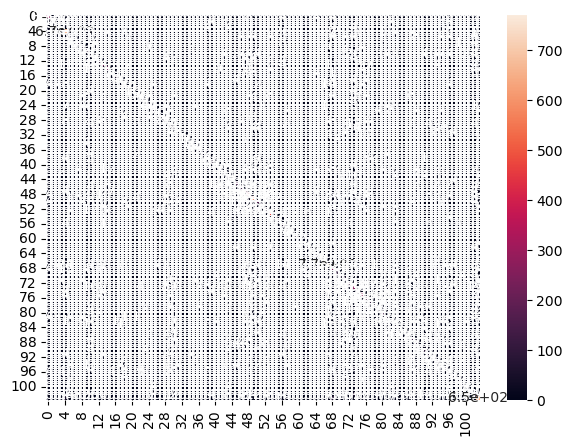

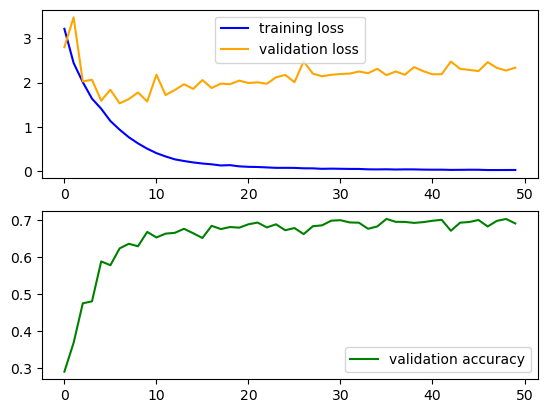

In [15]:
ne = 50
perform_training(NUM_EPOCHS=ne, TEST_FREQUENCY=1)

In [16]:
# Save the classifier network
# Suggestion: you can save checkpoints of your network during training and reload them later
if model_name is None:
    model_savename = f"trained_models/modeldate{str(datetime.now()).replace(':', '_')}_convlayers{N_CONV_LAYERS}_fclayers{N_FC_LAYERS}_bs{BS}_wd{WD}_at{AT}_epochs{ne}_lr_{LR}.pth"
else:
    model_savename = f"trained_models/modeldate{str(datetime.now()).replace(':', '_')}_PRETRAINEDMODEL{model_name}_bs{BS}_wd{WD}_epochs{ne}_lr_{LR}.pth"
    
torch.save(classifier.state_dict(), model_savename)

notification.notify(
    title = 'Done training and saving model!',
    message = 'message',
    app_icon = None,
    timeout = 10,
)

# Output predictions on test set

Accuracy: 0.0226
Validation/testing loss: 29.378419227228132
Finished testing.  Testing accuracy was 0.02262259550257383.  Test loss was 29.378419227228132.


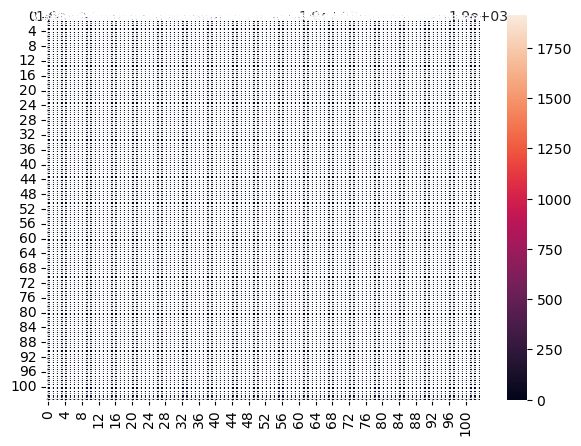

In [17]:
ds_test = PRODUCE_TESTING_DATASET()

test_loader = torch.utils.data.DataLoader(dataset=ds_test,
                                               batch_size=BS, 
                                               shuffle=False,
                                               num_workers=1)

accuracy, test_loss, guesses = test_classifier(test_loader, classifier, criterion, show_confusion_matrix=True, return_guesses=True)

print(f"Finished testing.  Testing accuracy was {accuracy}.  Test loss was {test_loss}.")
# This'll probably be low because all classes are disguised from the grader as 0.  Submit to Kaggle for true score.

In [18]:
output_submission_csv('my_solution.csv', guesses)
os.system("python remove_every_other_line_from_csv.py")

NameError: name 'output_submission_csv' is not defined